In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score,classification_report, confusion_matrix, ConfusionMatrixDisplay

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

In [2]:
data = pd.read_csv("data/entregas_paqueteria.csv")
data.head()

,Distancia_km,Indice_Trafico,Indice_Clima,Paradas_Previas,Experiencia_Repartidor_meses,Hora_Dia,Zona_Riesgo,Peso_kg,Entrega_Tarde
0,17.22,59.7,3.3,8,58.7,17,0.087,16.64,1
1,1.82,64.2,5.2,6,59.4,16,0.460,11.61,0
2,5.90,55.4,6.7,2,4.4,12,0.473,3.61,0
3,5.02,16.4,0.1,4,13.5,12,0.300,12.27,0
4,4.81,19.2,5.6,6,20.0,12,0.083,17.19,0


In [3]:
data.shape

(650, 9)

In [4]:
data.describe()

,Distancia_km,Indice_Trafico,Indice_Clima,Paradas_Previas,Experiencia_Repartidor_meses,Hora_Dia,Zona_Riesgo,Peso_kg,Entrega_Tarde
count,650.000000,650.000000,650.000000,650.000000,650.000000,650.000000,650.000000,650.000000,650.000000
mean,12.859769,55.005077,4.800923,4.392308,29.522154,13.663077,0.496434,10.291215,0.687692
std,7.072714,25.291095,2.849107,2.771460,17.466800,4.835222,0.281528,5.472492,0.463791
min,0.500000,10.300000,0.000000,0.000000,0.000000,6.000000,0.002000,0.520000,0.000000
25%,6.942500,33.625000,2.400000,2.000000,13.925000,10.000000,0.272250,5.810000,0.000000
50%,12.335000,55.550000,4.700000,4.000000,28.950000,13.000000,0.484500,10.770000,1.000000
75%,19.060000,75.500000,7.275000,7.000000,45.100000,18.000000,0.726000,14.762500,1.000000
max,24.850000,100.000000,10.000000,9.000000,59.900000,22.000000,0.999000,19.970000,1.000000


In [5]:
X=data.iloc[:,0:8]
X.head()

,Distancia_km,Indice_Trafico,Indice_Clima,Paradas_Previas,Experiencia_Repartidor_meses,Hora_Dia,Zona_Riesgo,Peso_kg
0,17.22,59.7,3.3,8,58.7,17,0.087,16.64
1,1.82,64.2,5.2,6,59.4,16,0.460,11.61
2,5.90,55.4,6.7,2,4.4,12,0.473,3.61
3,5.02,16.4,0.1,4,13.5,12,0.300,12.27
4,4.81,19.2,5.6,6,20.0,12,0.083,17.19


In [6]:
Y=data.iloc[:,8]
Y.head()

0    1
1    0
2    0
3    0
4    0
Name: Entrega_Tarde, dtype: int64

In [7]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.2, stratify=Y, random_state=42)

In [8]:
cv_inner=StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
pipelines = {
    "KNN": Pipeline([("scaler", StandardScaler()),
                     ("model", KNeighborsClassifier())]),
    "SVC": Pipeline([("scaler", StandardScaler()),
                     ("model", SVC())]),
    "Tree": Pipeline([("model", DecisionTreeClassifier())]),
    "Bayes": Pipeline([("model", GaussianNB())])
}

In [10]:
param_grids = {
    "KNN": {
        "model__n_neighbors": [5,7,8,9],
        "model__weights": ["uniform", "distance"]
    },
    "SVC": {
        "model__C": [0.1,1,10],
        "model__kernel": ["rbf", "linear"]
    },
    "Tree": {
        "model__max_depth": [None,3,5,10]
    },
    "Bayes": {
        "model__var_smoothing": [1e-9,1e-8,1e-7]
    }
}

In [11]:
best_models={}
resuls={}
for name in pipelines:
    grid=GridSearchCV(estimator=pipelines[name], param_grid=param_grids[name],cv=cv_inner, scoring="accuracy", n_jobs=-1)
    grid.fit(X_train, Y_train)
    best_models[name]=grid.best_estimator_
    resuls[name]={"Best params": grid.best_params_, "CV Accuracy": grid.best_score_}

In [12]:
for name, model in best_models.items():
    y_pred=model.predict(X_test)
    test_acc=accuracy_score(Y_test,y_pred)
    resuls[name]["Test accuracy"]=test_acc

In [13]:
pd.set_option("display.max_colwidth", None)
result_data=pd.DataFrame(resuls).T
result_data

,Best params,CV Accuracy,Test accuracy
KNN,"{'model__n_neighbors': 8, 'model__weights': 'distance'}",0.844231,0.807692
SVC,"{'model__C': 1, 'model__kernel': 'rbf'}",0.876923,0.907692
Tree,{'model__max_depth': 5},0.907692,0.884615
Bayes,{'model__var_smoothing': 1e-09},0.840385,0.892308


KNN
              precision    recall  f1-score   support

           0       0.75      0.59      0.66        41
           1       0.83      0.91      0.87        89

    accuracy                           0.81       130
   macro avg       0.79      0.75      0.76       130
weighted avg       0.80      0.81      0.80       130



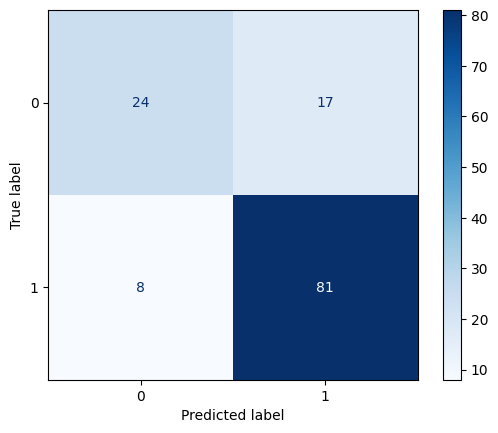

SVC
              precision    recall  f1-score   support

           0       0.89      0.80      0.85        41
           1       0.91      0.96      0.93        89

    accuracy                           0.91       130
   macro avg       0.90      0.88      0.89       130
weighted avg       0.91      0.91      0.91       130



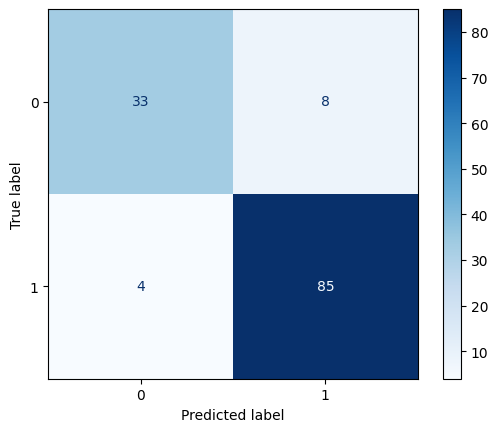

Tree
              precision    recall  f1-score   support

           0       0.84      0.78      0.81        41
           1       0.90      0.93      0.92        89

    accuracy                           0.88       130
   macro avg       0.87      0.86      0.86       130
weighted avg       0.88      0.88      0.88       130



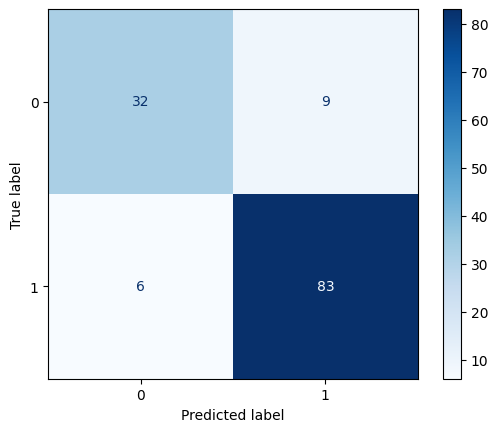

Bayes
              precision    recall  f1-score   support

           0       0.94      0.71      0.81        41
           1       0.88      0.98      0.93        89

    accuracy                           0.89       130
   macro avg       0.91      0.84      0.87       130
weighted avg       0.90      0.89      0.89       130



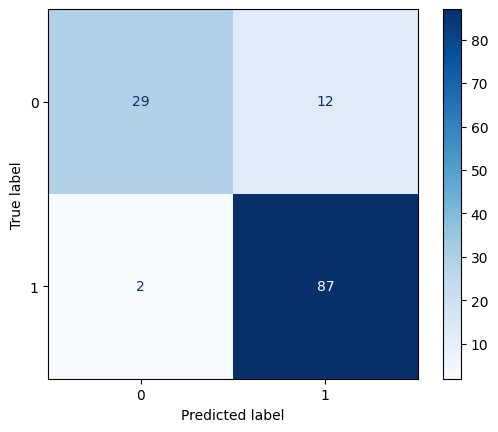

In [15]:
for name, model in best_models.items():
    y_pred=model.predict(X_test)
    print(name)
    print(classification_report(Y_test, y_pred))
    ConfusionMatrixDisplay.from_estimator(model, X_test, Y_test, cmap="Blues")
    plt.show()